In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold

In [2]:
# Import the training data
train_df = pd.read_csv('data/train.csv')
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [3]:
# Split up the data into training and testing
group_k_fold = GroupKFold(n_splits=5)
groups = train_df['patient_id'].values

# fold_number for splitting
fold_number = np.zeros(len(train_df))

# Create the groups and save the data
for index, (train_index, test_index) in enumerate(group_k_fold.split(train_df, groups=groups)):
    fold_number[test_index] = index
    
train_df['fold_number'] = fold_number.astype(np.int8)
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold_number
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,1


In [4]:
# Train and test split we will use the test data only for evaluation
X_train = train_df.loc[train_df['fold_number'] != 4]

X_test = train_df.loc[train_df['fold_number'] == 4]

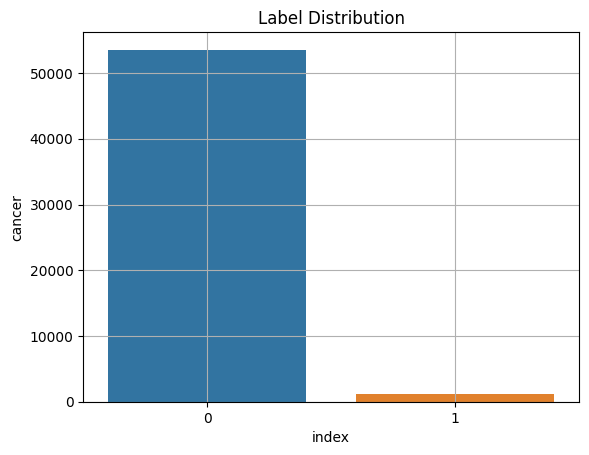

In [5]:
import seaborn as sns

ax = sns.barplot(
    data=train_df['cancer'].value_counts().reset_index(),
    x='index',
    y='cancer',
)
ax.set_title('Label Distribution')
ax.grid()

In [6]:
X_train.to_parquet('./data/training_data.parquet', index=False)
X_test.to_parquet('./data/test_data.parquet', index=False)

In [7]:
X_train.dtypes

site_id                      int64
patient_id                   int64
image_id                     int64
laterality                  object
view                        object
age                        float64
cancer                       int64
biopsy                       int64
invasive                     int64
BIRADS                     float64
implant                      int64
density                     object
machine_id                   int64
difficult_negative_case       bool
fold_number                   int8
dtype: object

In [8]:
X_train['path'] = (
    X_train['patient_id'].astype(str)
    + '_'
    + X_train['image_id'].astype(str)
    + '.png'
)
X_train.head()

/tmp/ipykernel_10485/3141156483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['path'] = (


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold_number,path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,10006_462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,10006_1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,0,10006_1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,0,10006_1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,1,10011_220375232.png


In [9]:
from data import RSNABreastDataset

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, random_split

train_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Setup the train data loader
# image_train_path = '/kaggle/input/rsna-breast-cancer-1024-pngs/output'
image_train_path = './image_data/resized_images_512x512'
train_data = RSNABreastDataset(
    df=X_train,
    image_dir=image_train_path,
    transforms=train_transform,
)

train_data_loader = DataLoader(train_data, batch_size=4, shuffle=False)

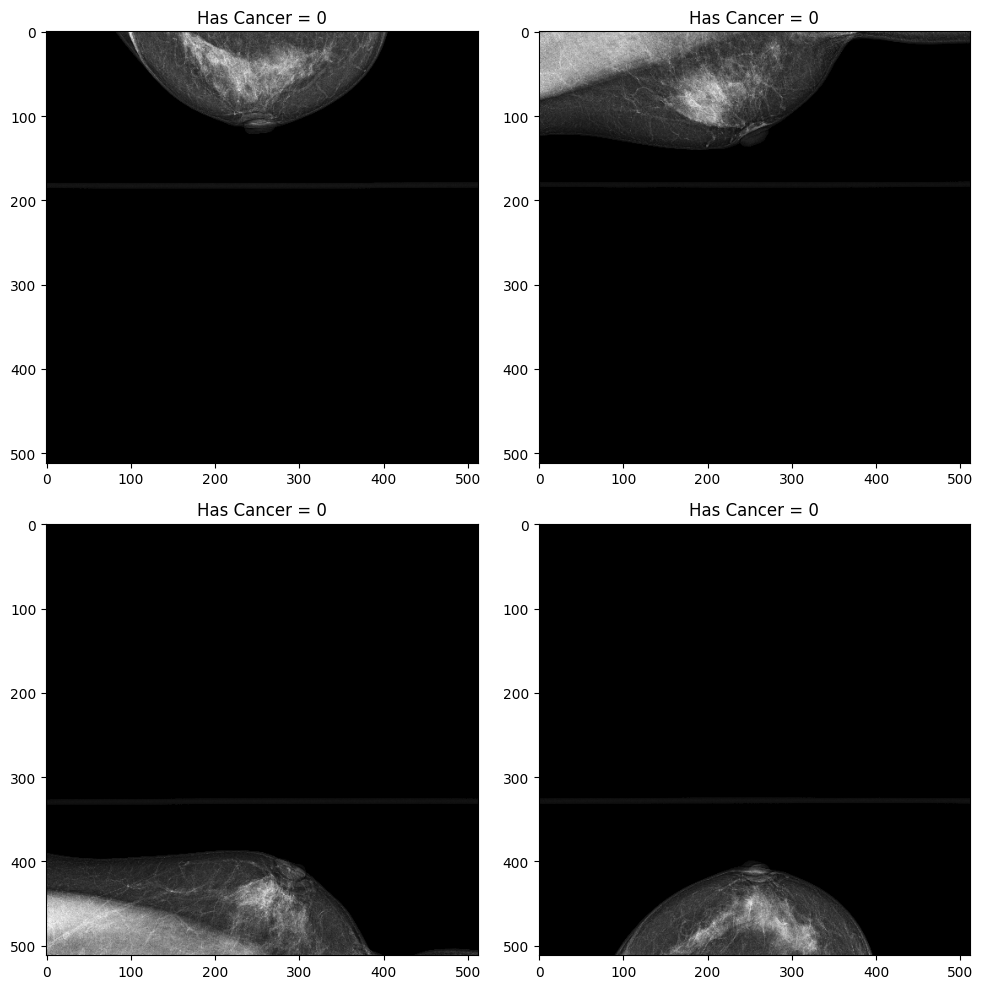

In [11]:
import matplotlib.pyplot as plt

# Iterate through the data and let's visualize!
train_features, train_labels, train_weights = next(iter(train_data_loader))

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for index, ax in enumerate(axes):
    image = train_features[index, :, :, :].squeeze().transpose(0, 2)
    label = int(train_labels[index])
    ax.imshow(image)
    ax.set_title(f'Has Cancer = {label}')
    
fig.tight_layout()

In [12]:
from models import RSNAEfficientnetModel
from utils import train_one_epoch, build_predictions, evaluate_model

/home/rydevera3/.virtualenvs/csci-5561-flying-dolphins/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
device = torch.device('cuda:0')

In [ ]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn import metrics
import torch.nn as nn
import numpy as np

# When we do cross validation we will do it as group k-fold because in the test data we will have
# completly different patients
n_splits = 5
group_kfold = StratifiedGroupKFold(n_splits=5)

indexes = np.arange(len(X_train))
y = X_train['cancer'].values
groups = X_train['patient_id'].values

# Setup the model and then save the weights as they are currently / no training
model = RSNAEfficientnetModel(pretrained=True).to(device=device)

# Set up optimizer
scaler = torch.cuda.amp.GradScaler(enabled=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(X=indexes, y=y, groups=groups)):
    print(f'Fold = {fold + 1}')
    
    # Set up the train and validation data
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    
    X_train_loader = DataLoader(train_data, batch_size=16, sampler=train_sampler)
    X_val_loader = DataLoader(train_data, batch_size=16, sampler=val_sampler)
    
    print(f'Number of samples in X_train_loader = {len(X_train_loader)}')
    print(f'Number of samples in X_val_loader = {len(X_val_loader)}')
    
    # Set up loss function
    train_labels = X_train_loader.dataset.labels
    pos_samples = train_labels.sum()
    pos_weight = torch.tensor(int(len(train_labels) / pos_samples))
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device=device)
    
    # Set model into training mode
    model.train()
    
    for epoch in range(10):
        # Train a single epoch
        train_predictions, train_labels = train_one_epoch(
            model=model,
            data_loader=X_train_loader,
            epoch=epoch,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
        )
        
        # Print training loss for epoch
        training_log_loss = metrics.log_loss(train_labels, train_predictions)
        training_aucroc = metrics.roc_auc_score(train_labels, train_predictions)
        print(f'Training log loss = {training_log_loss}')
        print(f'Training aucroc = {training_aucroc}')
        
        # Evaluate the model
        val_predictions, val_labels = build_predictions(
            model=model,
            data_loader=X_val_loader,
            device=device
        )
        
        # Print the evaluation metric
        val_log_loss = metrics.log_loss(val_labels, val_predictions)
        val_aucroc = metrics.roc_auc_score(val_labels, val_predictions)
        print(f'Val log loss = {val_log_loss}')
        print(f'Val aucroc = {val_aucroc}')
    
    if fold == 0:
        break

Fold = 1
Number of samples in X_train_loader = 2188
Number of samples in X_val_loader = 548


2188it [48:31,  1.33s/it]


Epoch = 0 / loss = 1.428031202875609
Training log loss = 0.6365437278409938
Training aucroc = 0.5208230338503633


0it [00:00, ?it/s]/home/rydevera3/.virtualenvs/csci-5561-flying-dolphins/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
407it [06:49,  1.01s/it]